In [4]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher as the libraries built for this course',
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda'
          'and then restart `jupyter notebook`:\n',
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    from scipy.ndimage.filters import gaussian_filter
    import IPython.display as ipyd
    import tensorflow as tf
    from libs import utils, gif, datasets, dataset_utils, vae, dft, vgg16, nb_utils
except ImportError:
    print("Make sure you have started notebook in the same directory",
          "as the provided zip file which includes the 'libs' folder",
          "and the file 'utils.py' inside of it.  You will NOT be able",
          "to complete this assignment unless you restart jupyter",
          "notebook inside the directory created by extracting",
          "the zip file or cloning the github repo.  If you are still")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [5]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [6]:
from libs import vgg16, inception, i2v

In [10]:
#sess.close()
tf.reset_default_graph()

# Stick w/ VGG for now, and then after you see how
# the next few sections work w/ this network, come back
# and explore the other networks.

net = vgg16.get_vgg_model()
# net = vgg16.get_vgg_face_model()
# net = inception.get_inception_model(version='v5')
# net = inception.get_inception_model(version='v3')
# net = i2v.get_i2v_model()
# net = i2v.get_i2v_tag_model()

In [11]:
# Let's explicity use the CPU, since we don't gain anything using the GPU
# when doing Deep Dream (it's only a single image, benefits come w/ many images).
device = '/cpu:0'

# We'll now explicitly create a graph
g = tf.Graph()

In [12]:
# And here is a context manager.  We use the python "with" notation to create a context
# and create a session that only exists within this indent,  as soon as we leave it,
# the session is automatically closed!  We also tel the session which graph to use.
# We can pass a second context after the comma,
# which we'll use to be explicit about using the CPU instead of a GPU.
with tf.Session(graph=g) as sess, g.device(device):
    
    # Now load the graph_def, which defines operations and their values into `g`
    tf.import_graph_def(net['graph_def'], name='net')

In [13]:
names = [op.name for op in g.get_operations()]

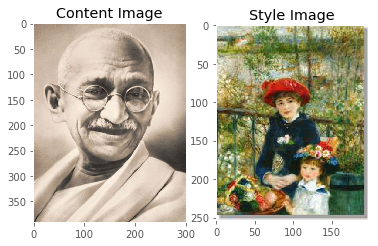

In [45]:
content_og = plt.imread('ghandi.jpg')[..., :3]
style_og = plt.imread('style.jpg')[..., :3]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_og)
axs[0].set_title('Content Image')
axs[0].grid('off')
axs[1].imshow(style_og)
axs[1].set_title('Style Image')
axs[1].grid('off')

# We'll save these with a specific name to include in your submission
plt.imsave(arr=content_og, fname='content.png')
plt.imsave(arr=style_og, fname='style.png')

In [46]:
content_img = net['preprocess'](content_og)[np.newaxis]
style_img = net['preprocess'](style_og)[np.newaxis]

In [47]:
# Grab the tensor defining the input to the network
x = g.get_tensor_by_name('net/images:0')

# And grab the tensor defining the softmax layer of the network
print(names[-2])
softmax = g.get_tensor_by_name(names[-2] + ":0")

net/prob


In [48]:
content_layer = 'net/conv3_2/conv3_2:0'

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_features = g.get_tensor_by_name(content_layer).eval(
            session=sess,
            feed_dict={x: content_img,
                    'net/dropout_1/random_uniform:0': np.ones([1,g.get_tensor_by_name('net/dropout_1/random_uniform:0').get_shape().as_list()[1]]),
                    'net/dropout/random_uniform:0': np.ones([1,g.get_tensor_by_name('net/dropout/random_uniform:0').get_shape().as_list()[1]])
                      }
            )[0]

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]

Caused by op 'Variable/read', defined at:
  File "/home/tsu-nera/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/tsu-nera/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-a707b8224125>", line 121, in <module>
    net_input = tf.Variable(content_img / 255.0)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 197, in __init__
    expected_shape=expected_shape)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 315, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1490, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/tsu-nera/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable)]]


In [24]:
# Experiment with different layers and layer subsets.  You'll need to change these
# if you use a different network!
style_layers = ['net/conv1_1/conv1_1:0',
                'net/conv2_1/conv2_1:0',
                'net/conv3_1/conv3_1:0',
                'net/conv4_1/conv4_1:0',
                'net/conv5_1/conv5_1:0']
style_activations = []

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    for style_i in style_layers:
        style_activation_i = g.get_tensor_by_name(style_i).eval(
             feed_dict={x: style_img,
                    'net/dropout_1/random_uniform:0': np.ones([1,g.get_tensor_by_name('net/dropout_1/random_uniform:0').get_shape().as_list()[1]]),
                    'net/dropout/random_uniform:0': np.ones([1,g.get_tensor_by_name('net/dropout/random_uniform:0').get_shape().as_list()[1]])
                      }
            )[0]
        style_activations.append(style_activation_i)

In [25]:
style_features = []
for style_activation_i in style_activations:
    s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]])
    gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
    style_features.append(gram_matrix.astype(np.float32))

In [50]:
dirname = 'separate-gif'


# Load every image file in the provided directory
filenames = [os.path.join(dirname, fname)
             for fname in os.listdir(dirname)]

# Make sure we have exactly 100 image files!
#filenames = filenames[:10]
num_ficheros = len(filenames)
print(num_ficheros)

23


In [54]:
dirresultname = 'processed/'

separate-18.gif
%f de %f:%s (1, 23, 'separate-18.gif')
separate-09.gif
%f de %f:%s (2, 23, 'separate-09.gif')
separate-15.gif
%f de %f:%s (3, 23, 'separate-15.gif')
separate-03.gif
%f de %f:%s (4, 23, 'separate-03.gif')
separate-06.gif
%f de %f:%s (5, 23, 'separate-06.gif')
separate-05.gif
%f de %f:%s (6, 23, 'separate-05.gif')
separate-16.gif
%f de %f:%s (7, 23, 'separate-16.gif')
separate-13.gif
%f de %f:%s (8, 23, 'separate-13.gif')
separate-21.gif
%f de %f:%s (9, 23, 'separate-21.gif')
separate-11.gif
%f de %f:%s (10, 23, 'separate-11.gif')
separate-04.gif
%f de %f:%s (11, 23, 'separate-04.gif')
separate-07.gif
%f de %f:%s (12, 23, 'separate-07.gif')
separate-08.gif
%f de %f:%s (13, 23, 'separate-08.gif')
separate-01.gif
%f de %f:%s (14, 23, 'separate-01.gif')
separate-19.gif
%f de %f:%s (15, 23, 'separate-19.gif')
separate-00.gif
%f de %f:%s (16, 23, 'separate-00.gif')
separate-02.gif
%f de %f:%s (17, 23, 'separate-02.gif')
separate-14.gif
%f de %f:%s (18, 23, 'separate-14.gif')
s

/home/tsu-nera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


separate-20.gif
%f de %f:%s (22, 23, 'separate-20.gif')


/home/tsu-nera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


separate-22.gif
%f de %f:%s (23, 23, 'separate-22.gif')


/home/tsu-nera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


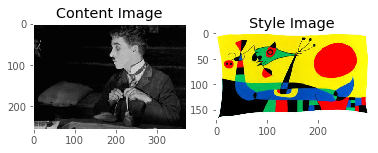

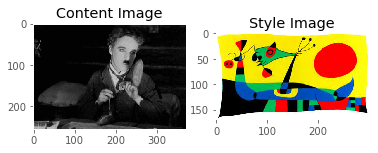

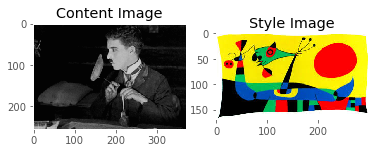

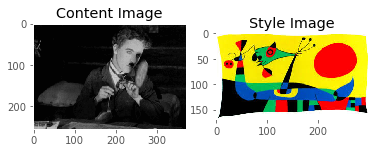

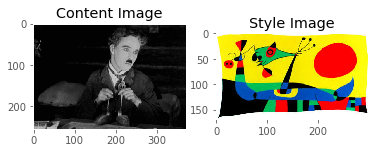

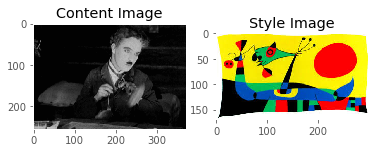

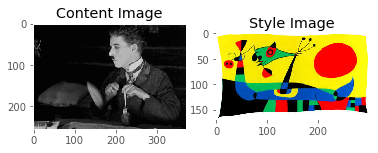

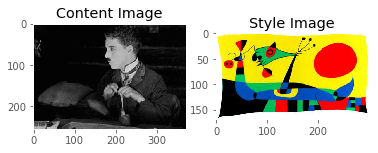

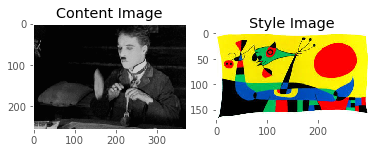

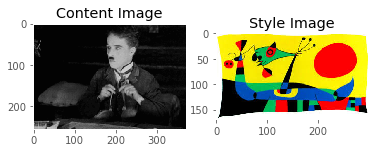

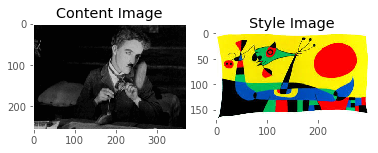

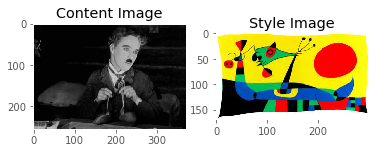

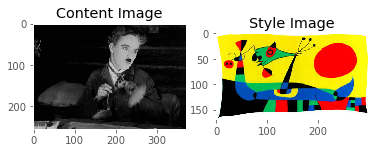

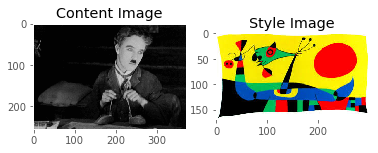

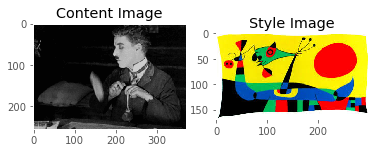

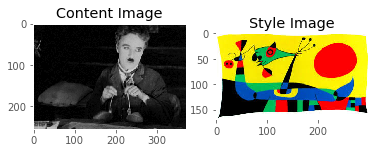

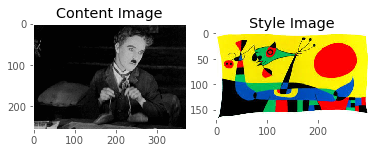

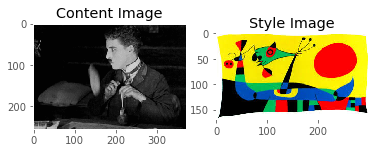

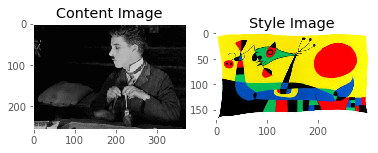

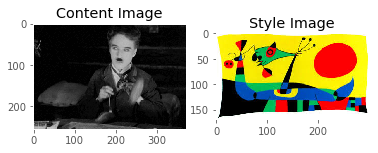

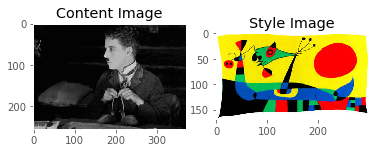

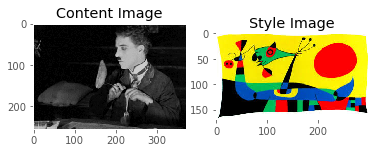

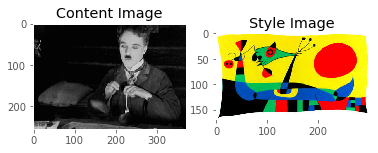

In [57]:
content_loss_factor  = 12.0
for style_loss_factor in [1.2]:
    for tv_loss_factor in [0.001]:            
        #dirresultname = "content_loss_{:f}_style_loss_{:f}_tv_loss_{:f}/".format(content_loss_factor, style_loss_factor, tv_loss_factor)
        #print(dirresultname)
        i = 0 
        
        for f_imagen in filenames:
            i = i + 1
            print(os.path.basename(f_imagen))
            print("%f de %f:%s", (i, num_ficheros, os.path.basename(f_imagen)))
            
            sess.close()
            tf.reset_default_graph()
            net = vgg16.get_vgg_model()

            # Let's explicity use the CPU, since we don't gain anything using the GPU
            # when doing Deep Dream (it's only a single image, benefits come w/ many images).
            device = '/cpu:0'

            # We'll now explicitly create a graph
            g = tf.Graph()


            # And here is a context manager.  We use the python "with" notation to create a context
            # and create a session that only exists within this indent,  as soon as we leave it,
            # the session is automatically closed!  We also tel the session which graph to use.
            # We can pass a second context after the comma,
            # which we'll use to be explicit about using the CPU instead of a GPU.
            with tf.Session(graph=g) as sess, g.device(device):

                # Now load the graph_def, which defines operations and their values into `g`
                tf.import_graph_def(net['graph_def'], name='net')    

            names = [op.name for op in g.get_operations()]            

            content_og = plt.imread(f_imagen)[..., :3]
            style_og = plt.imread('miro2.jpg')[..., :3]

            fig, axs = plt.subplots(1, 2)
            axs[0].imshow(content_og)
            axs[0].set_title('Content Image')
            axs[0].grid('off')
            axs[1].imshow(style_og)
            axs[1].set_title('Style Image')
            axs[1].grid('off')

            content_img = net['preprocess'](content_og)[np.newaxis]
            style_img = net['preprocess'](style_og)[np.newaxis]   


            # Grab the tensor defining the input to the network
            x = g.get_tensor_by_name('net/images:0')

            # And grab the tensor defining the softmax layer of the network
            #print(names[-2])
            softmax = g.get_tensor_by_name(names[-2] + ":0")

            for img in [content_img, style_img]:
                with tf.Session(graph=g) as sess, g.device('/cpu:0'):
                    # Remember from the lecture that we have to set the dropout
                    # "keep probability" to 1.0.
                    res = softmax.eval(feed_dict={x: img,
                                                  'net/dropout_1/random_uniform:0': np.ones([1,g.get_tensor_by_name('net/dropout_1/random_uniform:0').get_shape().as_list()[1]]),
                                                  'net/dropout/random_uniform:0': np.ones([1,g.get_tensor_by_name('net/dropout/random_uniform:0').get_shape().as_list()[1]])})[0]
                    #print([(res[idx], net['labels'][idx])
                    #       for idx in res.argsort()[-5:][::-1]])    



            # Experiment w/ different layers here.  You'll need to change this if you 
            # use another network!
            content_layer = 'net/conv3_2/conv3_2:0'

            with tf.Session(graph=g) as sess, g.device('/cpu:0'):
                content_features = g.get_tensor_by_name(content_layer).eval(
                    session=sess,
                    feed_dict={x: content_img,
                               'net/dropout_1/random_uniform:0': np.ones([1,g.get_tensor_by_name('net/dropout_1/random_uniform:0').get_shape().as_list()[1]]),
                               'net/dropout/random_uniform:0': np.ones([1,g.get_tensor_by_name('net/dropout/random_uniform:0').get_shape().as_list()[1]])
                              }
                )[0]

            # Experiment with different layers and layer subsets.  You'll need to change these
            # if you use a different network!
            style_layers = ['net/conv1_1/conv1_1:0',
                            'net/conv2_1/conv2_1:0',
                            'net/conv3_1/conv3_1:0',
                            'net/conv4_1/conv4_1:0',
                            'net/conv5_1/conv5_1:0']
            style_activations = []

            with tf.Session(graph=g) as sess, g.device('/cpu:0'):
                for style_i in style_layers:
                    style_activation_i = g.get_tensor_by_name(style_i).eval(
                        feed_dict={x: style_img,
                                   'net/dropout_1/random_uniform:0': np.ones([1,g.get_tensor_by_name('net/dropout_1/random_uniform:0').get_shape().as_list()[1]]),
                                   'net/dropout/random_uniform:0': np.ones([1,g.get_tensor_by_name('net/dropout/random_uniform:0').get_shape().as_list()[1]])
                                  }
                    )[0]
                    style_activations.append(style_activation_i)   

            style_features = []
            for style_activation_i in style_activations:
                s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]])
                gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
                style_features.append(gram_matrix.astype(np.float32))    


            tf.reset_default_graph()
            g = tf.Graph()

            # Get the network again
            net = vgg16.get_vgg_model()

            # Load up a session which we'll use to import the graph into.
            with tf.Session(graph=g) as sess, g.device('/cpu:0'):
                # We can set the `net_input` to our content image
                # or perhaps another image
                # or an image of noise
                net_input = tf.Variable(content_img / 255.0)
        #        net_input = tf.get_variable(
        #           name='input',
        #           shape=content_img.shape,
        #           dtype=tf.float32,
        #           initializer=tf.random_normal_initializer(
        #               mean=np.mean(content_img), stddev=np.std(content_img)))

                # Now we load the network again, but this time replacing our placeholder
                # with the trainable tf.Variable
                tf.import_graph_def(
                    net['graph_def'],
                    name='net',
                    input_map={'images:0': net_input})   


            with tf.Session(graph=g) as sess, g.device('/cpu:0'):
                content_loss = tf.nn.l2_loss((g.get_tensor_by_name(content_layer) -
                                             content_features) /
                                             content_features.size)   


            with tf.Session(graph=g) as sess, g.device('/cpu:0'):
                style_loss = np.float32(0.0)
                for style_layer_i, style_gram_i in zip(style_layers, style_features):
                    layer_i = g.get_tensor_by_name(style_layer_i)
                    layer_shape = layer_i.get_shape().as_list()
                    layer_size = layer_shape[1] * layer_shape[2] * layer_shape[3]
                    layer_flat = tf.reshape(layer_i, [-1, layer_shape[3]])
                    gram_matrix = tf.matmul(tf.transpose(layer_flat), layer_flat) / layer_size
                    style_loss = tf.add(style_loss, tf.nn.l2_loss((gram_matrix - style_gram_i) / np.float32(style_gram_i.size)))    

            def total_variation_loss(x):
                h, w = x.get_shape().as_list()[1], x.get_shape().as_list()[1]
                dx = tf.square(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
                dy = tf.square(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
                return tf.reduce_sum(tf.pow(dx + dy, 1.25))

            with tf.Session(graph=g) as sess, g.device('/cpu:0'):
                tv_loss = total_variation_loss(net_input)    


            with tf.Session(graph=g) as sess, g.device('/cpu:0'):
                # Experiment w/ the weighting of these!  They produce WILDLY different
                # results.
                #loss = 5.0 * content_loss + 1.0 * style_loss + 0.001 * tv_loss
                loss = content_loss_factor * content_loss + style_loss_factor * style_loss + tv_loss_factor * tv_loss
                optimizer = tf.train.AdamOptimizer(0.05).minimize(loss)   


            imgs = []
            n_iterations = 100

            with tf.Session(graph=g) as sess, g.device('/cpu:0'):
                sess.run(tf.global_variables_initializer())

                # map input to noise
                og_img = net_input.eval()

                for it_i in range(n_iterations):
                    _, this_loss, synth = sess.run([optimizer, loss, net_input], feed_dict={
                                'net/dropout_1/random_uniform:0': np.ones(
                                    g.get_tensor_by_name(
                                        'net/dropout_1/random_uniform:0'
                                    ).get_shape().as_list()),
                                'net/dropout/random_uniform:0': np.ones(
                                    g.get_tensor_by_name(
                                        'net/dropout/random_uniform:0'
                                    ).get_shape().as_list())
                            })
                    #print("%d: %f, (%f - %f)" %
                    #    (it_i, this_loss, np.min(synth), np.max(synth)))
                    if it_i % 5 == 0:
                        m = vgg16.deprocess(synth[0])
                        imgs.append(m)
        #                plt.imshow(m)
        #                plt.show()
                plt.imsave(arr=m, fname=dirresultname + os.path.splitext(os.path.basename(f_imagen))[0] + '.png')                
        #        gif.build_gif(imgs, saveto='stylenet.gif')    

